(30.0, 85.0)

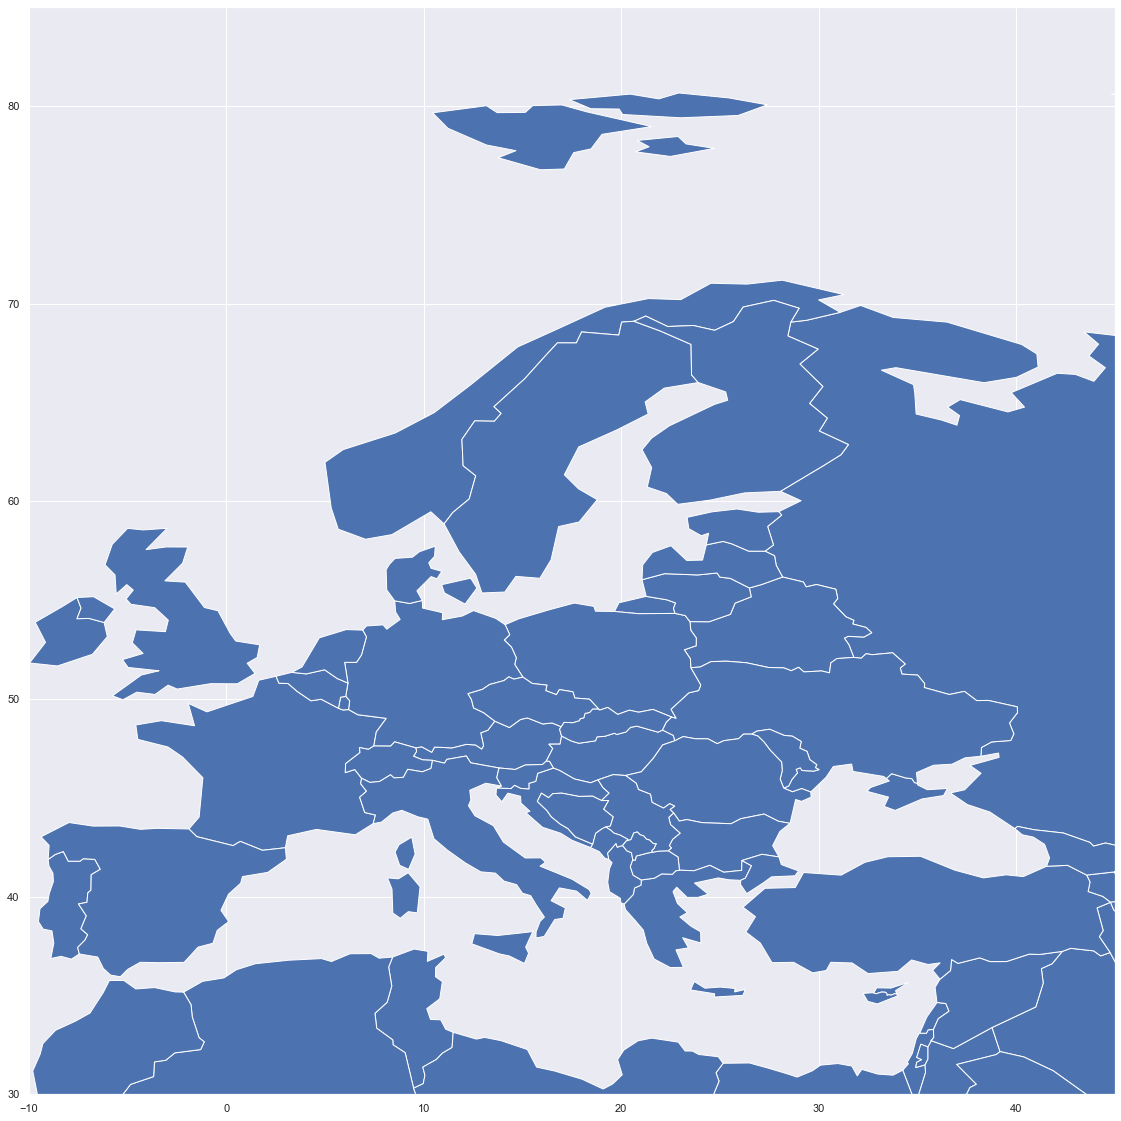

In [49]:
TEST = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
test_plot = TEST.plot()
test_plot.set_xlim(-10,45)
test_plot.set_ylim(30,85)

In [228]:
import pandas as pd
import numpy as np
import os
import glob
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn
import sklearn
from shapely.geometry import Point, Polygon, box
import scipy

seaborn.set()
# numpy pandas shapely geopandas rasterio
cwd_path = os.getcwd()
usa_quake_path = cwd_path + "\\earthquake_contiguous_usa_12batch\\"
eu_quake_path = cwd_path + "\\Earthquake_2016_2018_all_eu\\"

In [229]:
# Used to enumerate the files in each directory.
# Useful for finding a sepcific file's index for the us_df[] and eu_df[] arrays/list

for x, us in enumerate(glob.glob(usa_quake_path+"*.csv")):
    print("%2i %s" % (x,os.path.basename(us)))
print()
for x, eu in enumerate(glob.glob(eu_quake_path+"*.csv")):
    print("%2i %s" % (x,os.path.basename(eu)))

 0 Earthquake_2020_09_2020_10_filtered.csv
 1 Earthquake_2020_11_2020_12_filtered.csv
 2 Earthquake_2021_01_2021_02_filtered.csv
 3 Earthquake_2021_03_2021_04_filtered.csv
 4 Earthquake_2021_05_2021_06_filtered.csv
 5 Earthquake_2021_07_2021_08_filtered.csv
 6 Earthquake_2021_09_2021_10_filtered.csv
 7 Earthquake_2021_11_2021_12_filtered.csv
 8 Earthquake_2022_01_2022_02_filtered.csv
 9 Earthquake_2022_03_2022_04_filtered.csv
10 Earthquake_2022_05_2022_06_filtered.csv
11 Earthquake_2022_07_2022_08_filtered.csv

 0 Earthquake_2016_10_filtered_eu.csv
 1 Earthquake_2016_11_filtered_eu.csv
 2 Earthquake_2016_12_filtered_eu.csv
 3 Earthquake_2016_1_filtered_eu.csv
 4 Earthquake_2016_2_filtered_eu.csv
 5 Earthquake_2016_3_filtered_eu.csv
 6 Earthquake_2016_4_filtered_eu.csv
 7 Earthquake_2016_5_filtered_eu.csv
 8 Earthquake_2016_6_filtered_eu.csv
 9 Earthquake_2016_7_filtered_eu.csv
10 Earthquake_2016_8_filtered_eu.csv
11 Earthquake_2016_9_filtered_eu.csv
12 Earthquake_2017_10_filtered_eu.cs

In [270]:
# CSVs are appended to an array/list as DataFames.
# Done for both US and EU data
us_df = []
eu_df = []
for us in glob.glob(usa_quake_path+"*.csv"):
    us_df.append(pd.read_csv(us))


for eu in glob.glob(eu_quake_path+"*.csv"):
    eu_df.append(pd.read_csv(eu))

In [231]:
# filter 
def filter_batch(us_df):
    filtered_batch = []
    for i in us_df:
        current_df = i[i.mag >= 4.5]
        filtered_batch.append(current_df)
filtered_us_batches = filter_batch(us_df)

In [233]:
# Batch allocation 
us_batch = []
for y in range(10):
    batch = pd.concat((us_df[y+0], us_df[y+1], us_df[y+2]),ignore_index=True)
    us_batch.append(batch)

In [234]:
# Geo batch allocation
geo_us_batch = []
for y in range(10):
    geo_us_batch.append(gpd.GeoDataFrame(us_batch[y]))

# Breakdown
Imagine one batch
That one batch will be turned into a geodataframe
that one batch will have a grid with cells assigned to it based of longitude min and max
That grid will contain events that will be counted. each cell with have a number of events in it. 
That grid will then be analyzed and be given a "hotspot" visualization
That grid and hotspot visualziation will then be plotted on a map

In [235]:
#takes in geodataframes
def find_bounds(gdfs):
    lat_min_max_table =[];
    for x in geo_df:
        xmin, ymin, xmax, ymax= x.total_bounds
        lat_min_max_table.append([xmin,ymin,xmax,ymax])
    lat_min_max_df = pd.DataFrame(lat_min_max_table, columns =['xmin', 'ymin', 'xmax', 'ymax'])
    long_xmin = lat_min_max_df.xmin.min()
    long_xmax = lat_min_max_df.xmax.max()
    
    lat_ymin = lat_min_max_df.ymin.min()
    lat_ymax = lat_min_max_df.ymax.max()
    return long_xmin, lat_ymin, long_xmax, lat_ymax


In [236]:
# converts batch dataframes into batches of geodataframes

def geo_frames(dfs):
    geo_df = []
    for a in dfs:
        current_geo_df = gpd.GeoDataFrame(a,
                                          crs='epsg:4326',geometry=[Point(xy) for xy in zip(a.longitude, a.latitude)])
        # here is the filtering
        current_geo_df = current_geo_df[current_geo_df.mag >= 3]
        current_geo_df = current_geo_df[current_geo_df.depth <= 100]
        
        current_geo_df = current_geo_df.reset_index(drop=True)
        geo_df.append(current_geo_df)
    return geo_df

In [238]:
print(geo_df[0].total_bounds)
(find_bounds(geo_df))

[-124.2291667   29.2317     -67.1595      48.7652   ]


(-124.3288333, 28.45367432, -67.1595, 48.807833333333335)

In [247]:
# sets the grid overall bounds and cell bounds for each batch. 
# these bounds depend on the overal bounds, say |max(longitude) - min(longitude)| / n_cells

def set_grid(gdfs):
    cell_list = []
    xmin, ymin, xmax, ymax = find_bounds(gdfs)
    for i in gdfs:
        #xmin, ymin, xmax, ymax= i.total_bounds
        n_cells=45
        cell_size = (xmax-xmin)/n_cells
        
        grid_cells = []
        for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
            for y0 in np.arange(ymin, ymax+cell_size, cell_size):
                # bounds
                x1 = x0-cell_size
                y1 = y0+cell_size
                grid_cells.append( box(x0, y0, x1, y1)  )
        cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'],crs='epsg:4326')
        cell_list.append(cell)
    return cell_list

# Warning, this event_count function will take a while to run, about 5 mintues-ish

In [240]:
# for each batch, the number of events is counted for each cell in that batch
# returns an a list/array, one for each batch
# each subarray gives the number of events per each cell

def event_count(grid,gdf):
    if len(grid) != len(gdf):
        return print("length mismatch")
    count_list = []
    for x in range(len(grid)):
        min_max_table=[] # is an array of cells bounds for each cell
        geo_table=[]     # is an array of long and lat from batch(es)
        counter=[]       # is an array that holds occurences of quakes per cell

        # gives the min and max longs and lats for given cells (aka the bounds of the cell)
        for i in range(len(grid[x])):
            xmin, ymin, xmax, ymax= grid[x].loc[i].geometry.bounds
            min_max_table.append([xmin,ymin,xmax,ymax])
        # appends the points from the geodataframe 'Geometry.Point'
        for j in range(len(gdf[x])):
            geo_table.append([gdf[x].geometry.x[j], gdf[x].geometry.y[j]])
        for i in range(len(grid[x])):
            counter.append(0)
            for j in range(len(gdf[x])):
                if ((geo_table[j][0] < min_max_table[i][2]) & (geo_table[j][0] > min_max_table[i][0]) & (geo_table[j][1] < min_max_table[i][3]) & (geo_table[j][1] > min_max_table[i][1])):
                    counter[i] +=1
        count_list.append(counter)
    return count_list

In [241]:
# gets the grid with the hotspots/events in it and also returns the base grid used in analysis

def get_frame_ready(count_list,grid_list):
    hotspot_list = []
    geo_df_list = []
    for x in range(len(grid_list)):
        working_df = pd.DataFrame(grid_list[x].loc[:].geometry.bounds)
        working_df['counter'] = count_list[x]
        geometry_for_df = [box(x1,y1,x2,y2) for x1,y1,x2,y2
                           in zip(working_df.minx,working_df.miny, working_df.maxx,working_df.maxy)]
        bounds_df = gpd.GeoDataFrame(working_df.drop(['minx','miny','maxx','maxy'], axis=1), geometry=geometry_for_df)
        
        geo_df_list.append(bounds_df)
        hotspot_df = bounds_df.copy()
        hotspot_df[hotspot_df.counter == 0] = np.nan
        hotspot_list.append(hotspot_df)

    return hotspot_list, geo_df_list

In [266]:
# Plots the USA map, the hotspots, the grid itself, and the scatter points 
# takes in the long,lat geodataframe, the base grid used, the hotspots, the "density" we want

def poimagic(geo_df,base_grid, hotspot_grid,density):
    plt.rcParams["figure.figsize"] = [20, 20]
    states = gpd.read_file('data/usa-states-census-2014.shp')
    for x in range(len(geo_df)):
        state_plot = states.plot()
        hotspot_grid[x].plot(ax = state_plot, column="counter",edgecolor="black", cmap="viridis",vmax = density, alpha = 0.7)
        base_grid[x].plot(ax = state_plot, facecolor="None",edgecolor="black")
        plt.scatter( geo_df[x].longitude, geo_df[x].latitude,c="red",marker='.')

def poimagic(geo_df,base_grid, hotspot_grid,density):
    long_min, lat_min, long_max, lat_max = find_bounds(geo_df)
    plt.rcParams["figure.figsize"] = [20, 20]
    states = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    for x in range(len(geo_df)):
        state_plot = states.plot()
        state_plot.set_xlim(long_min-5,long_max+5)
        state_plot.set_ylim(lat_min-5,lat_max+5)
        
        hotspot_grid[x].plot(ax = state_plot, column="counter",edgecolor="black", cmap="viridis",vmax = density, alpha = 0.7)
        base_grid[x].plot(ax = state_plot, facecolor="None",edgecolor="black")
        plt.scatter( geo_df[x].longitude, geo_df[x].latitude,c="red",marker='.')

In [248]:
geo_df = geo_frames(us_batch)
grid_list = set_grid(geo_df)

In [250]:
count_list = event_count(grid_list,geo_df)
hotspot_grid, base_grid = get_frame_ready(count_list,grid_list)

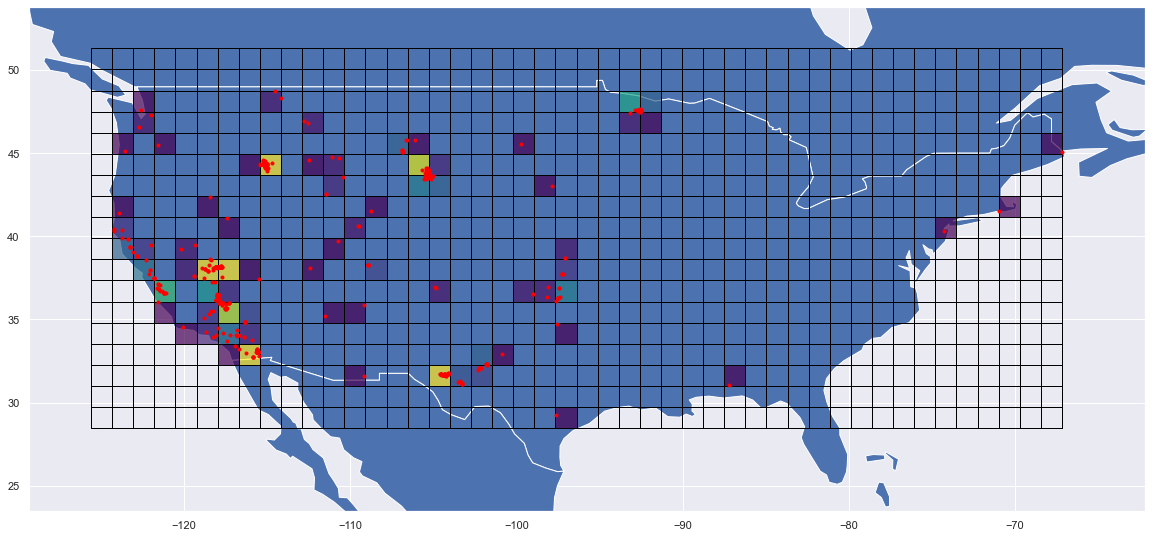

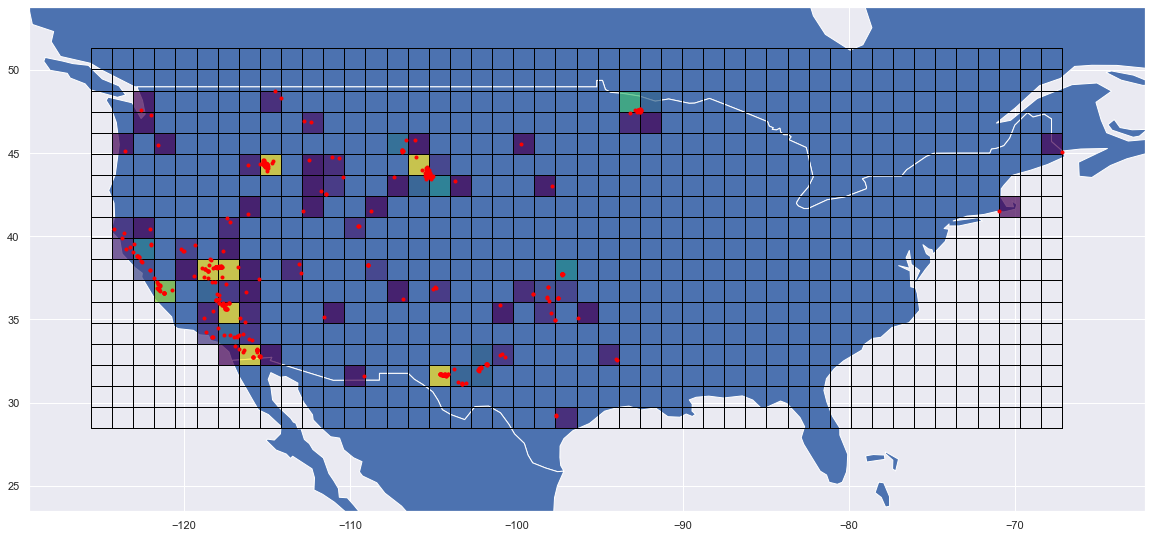

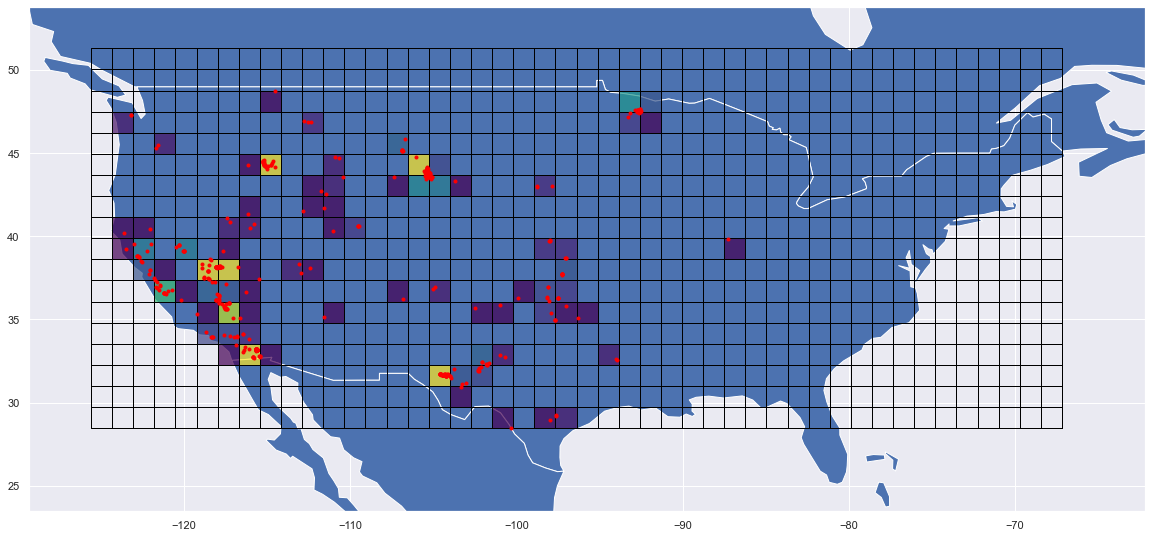

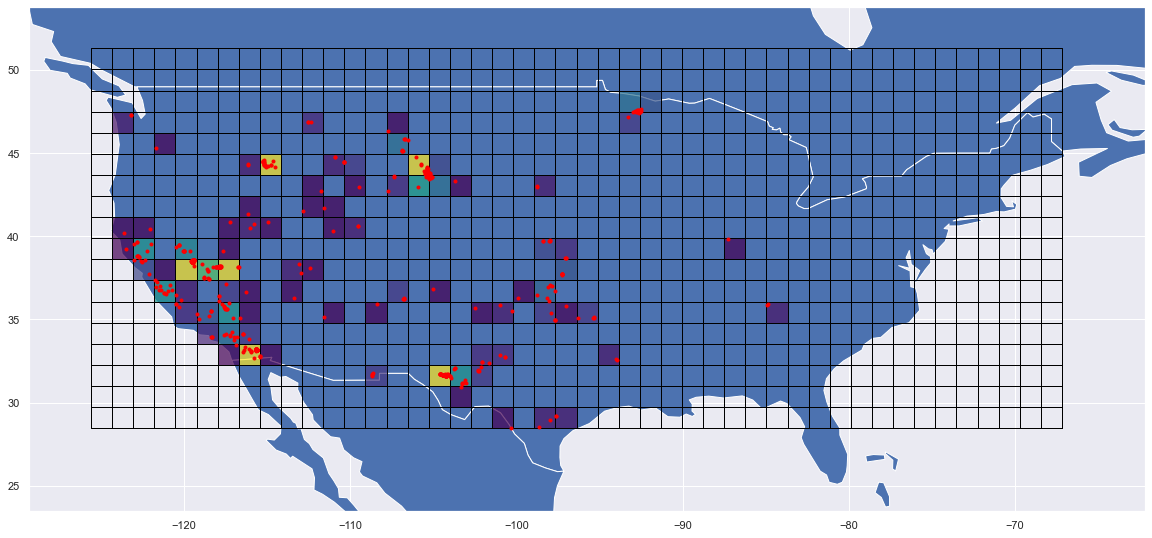

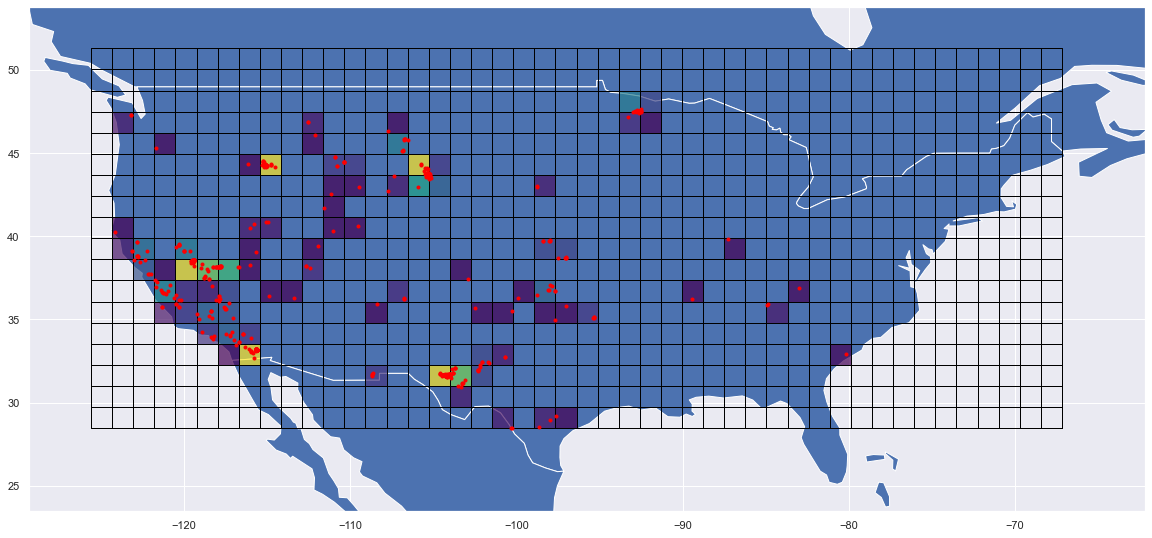

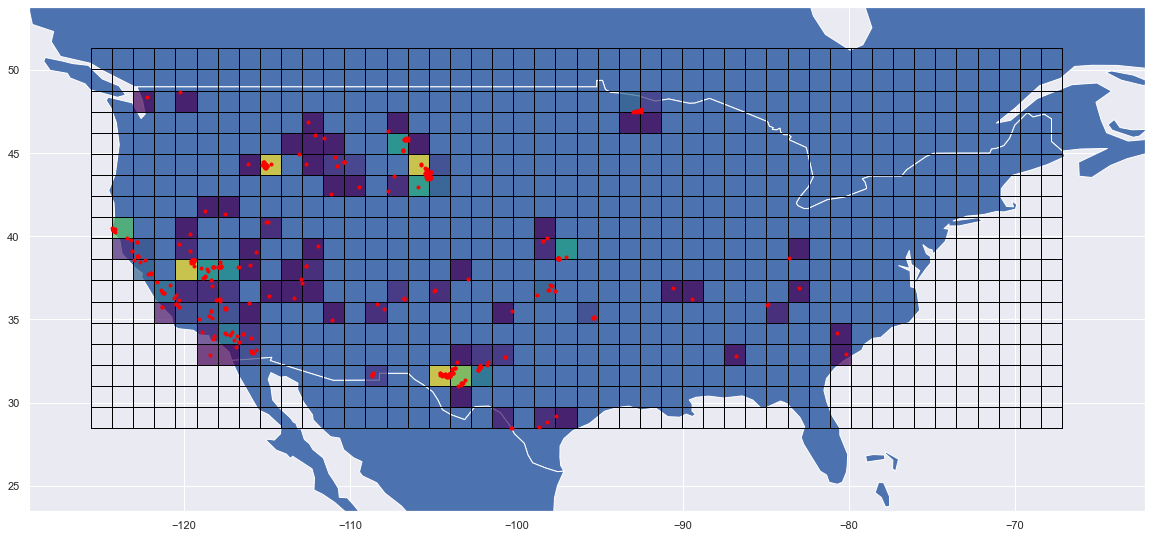

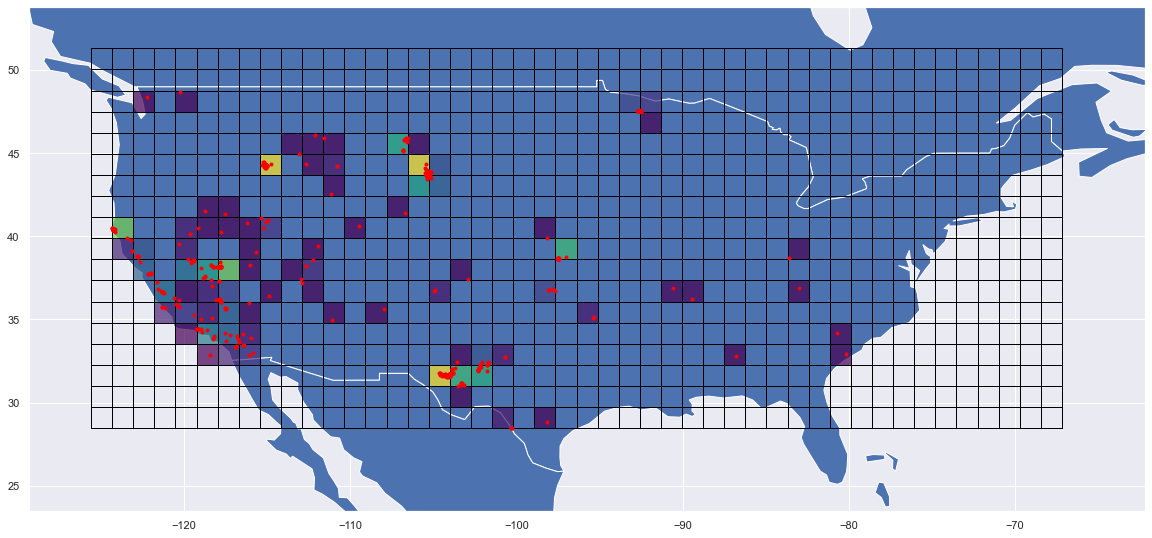

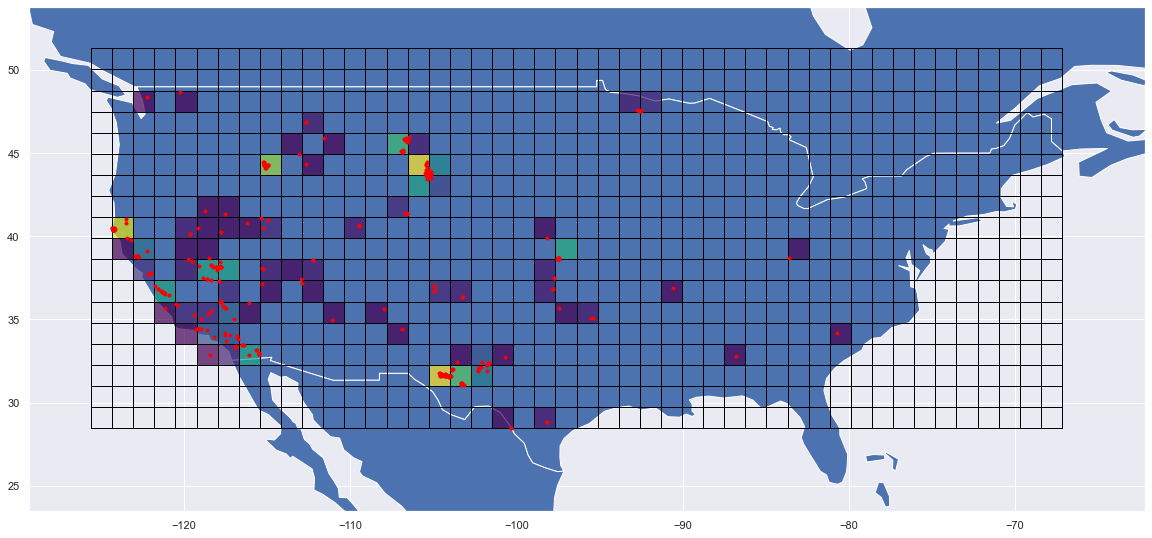

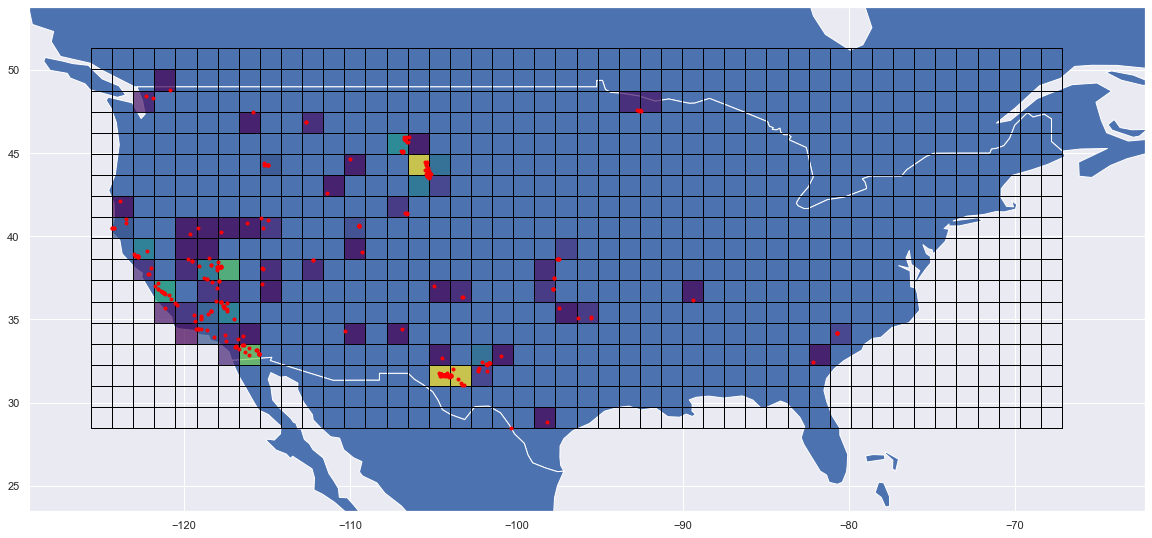

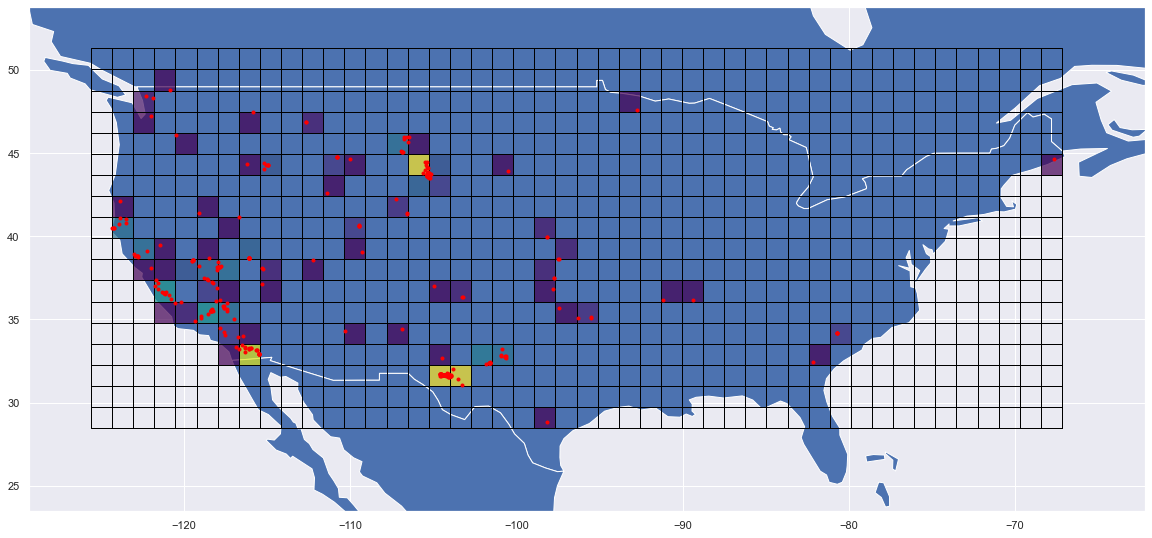

In [269]:
#poimagic(geo_df,base_grid,hotspot_grid,20)
poimagic(geo_df,base_grid,hotspot_grid,20)

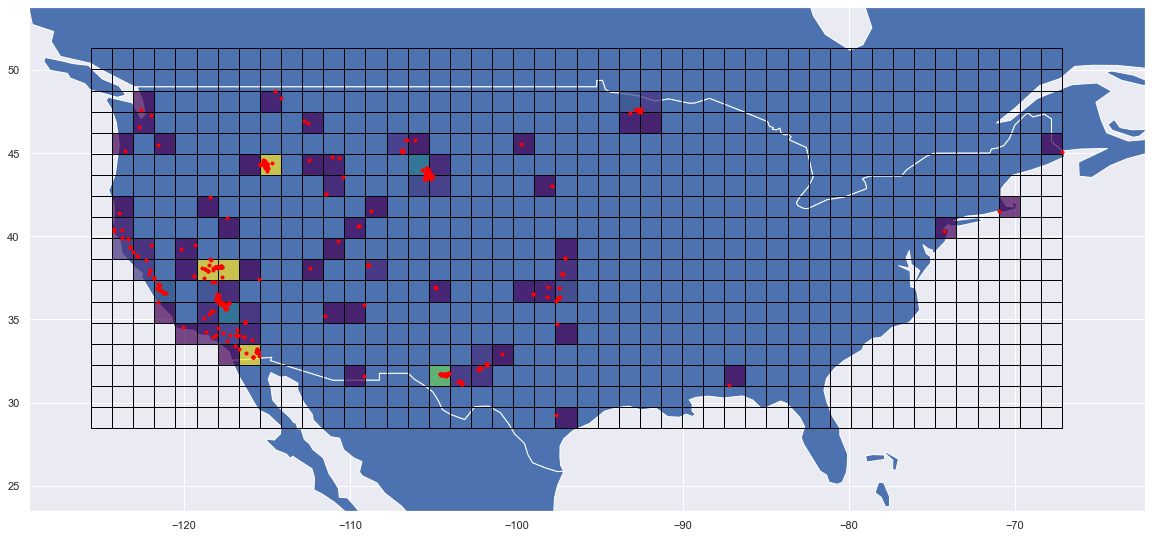

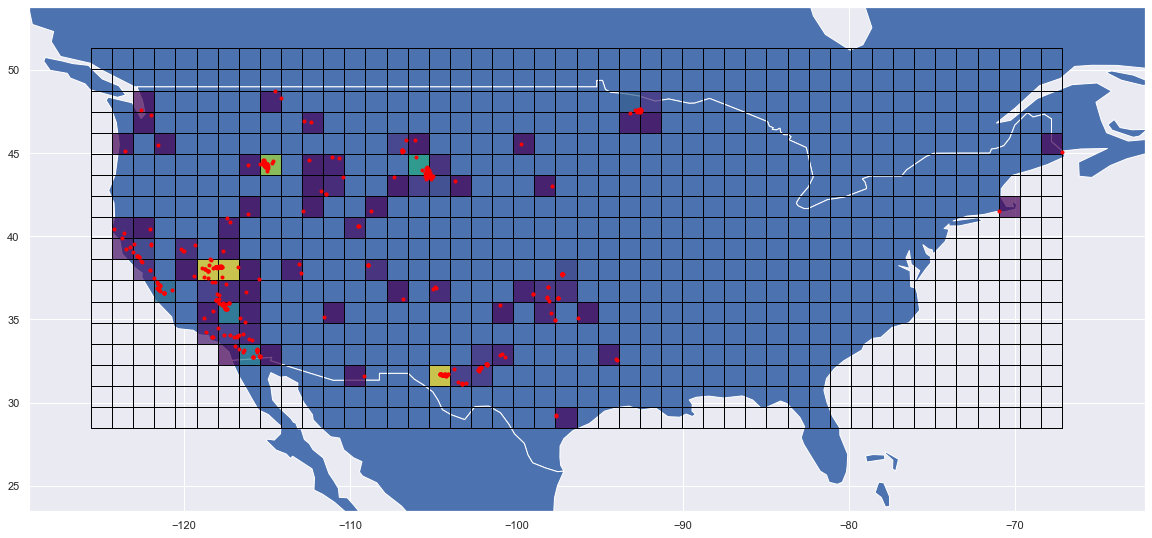

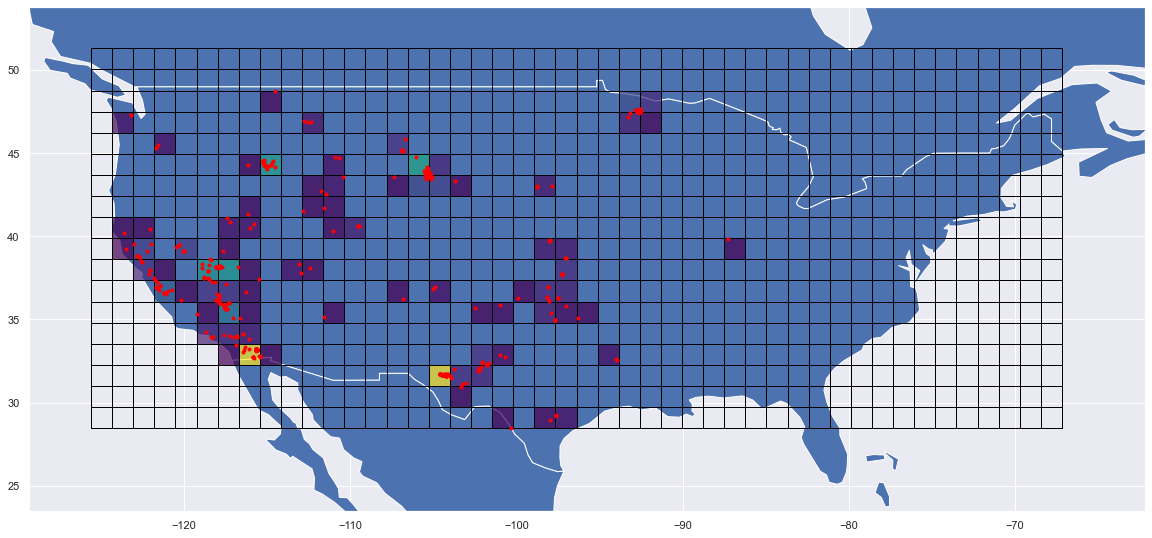

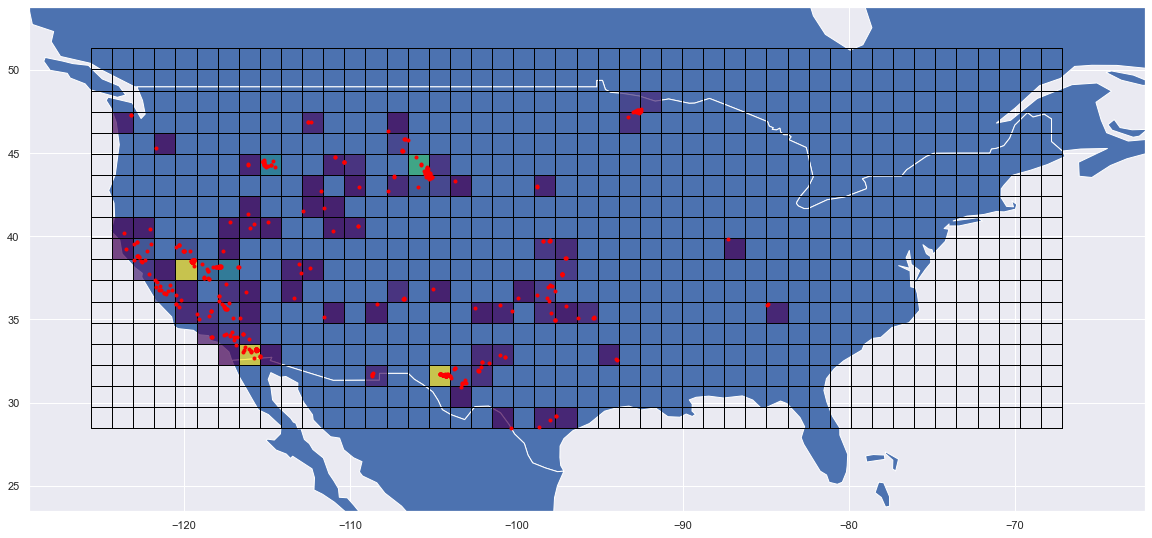

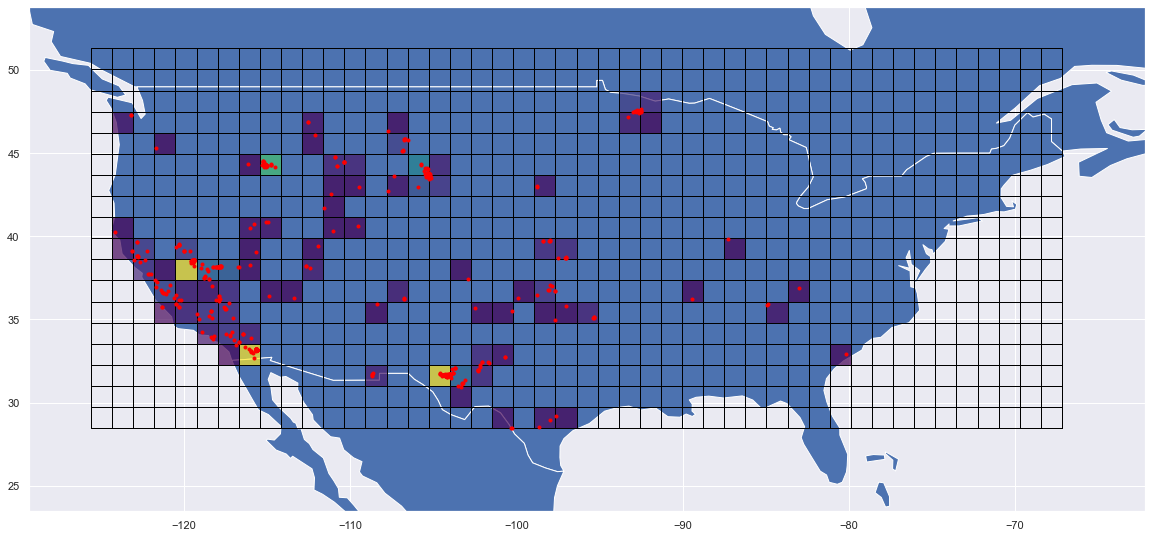

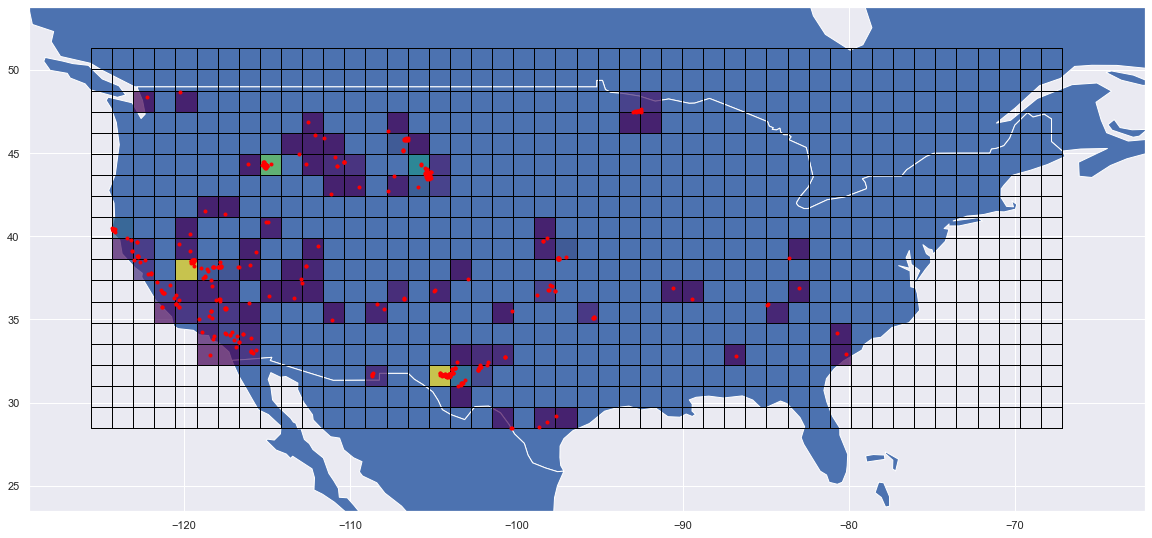

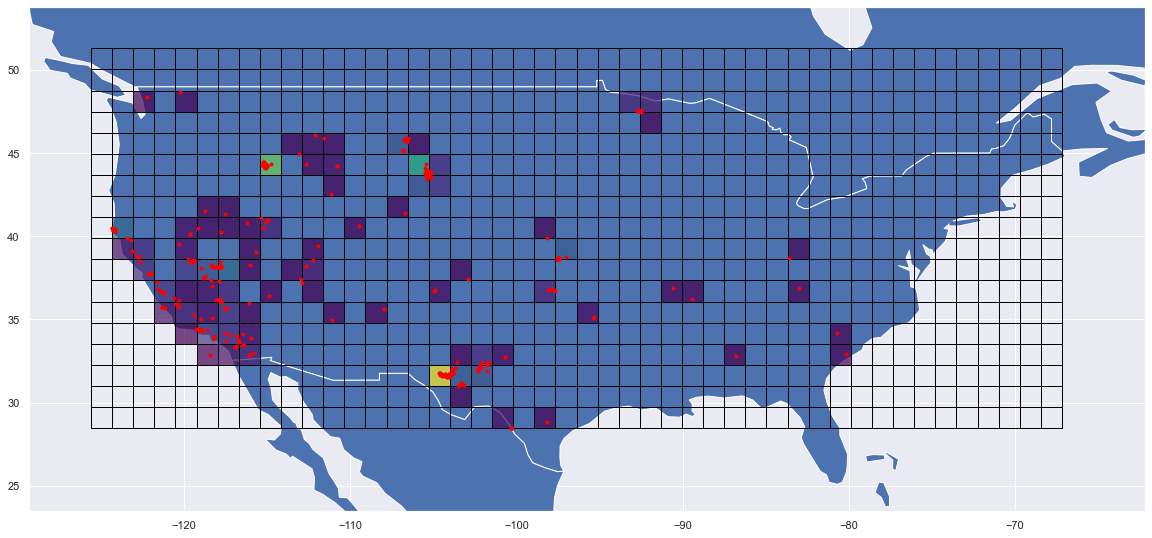

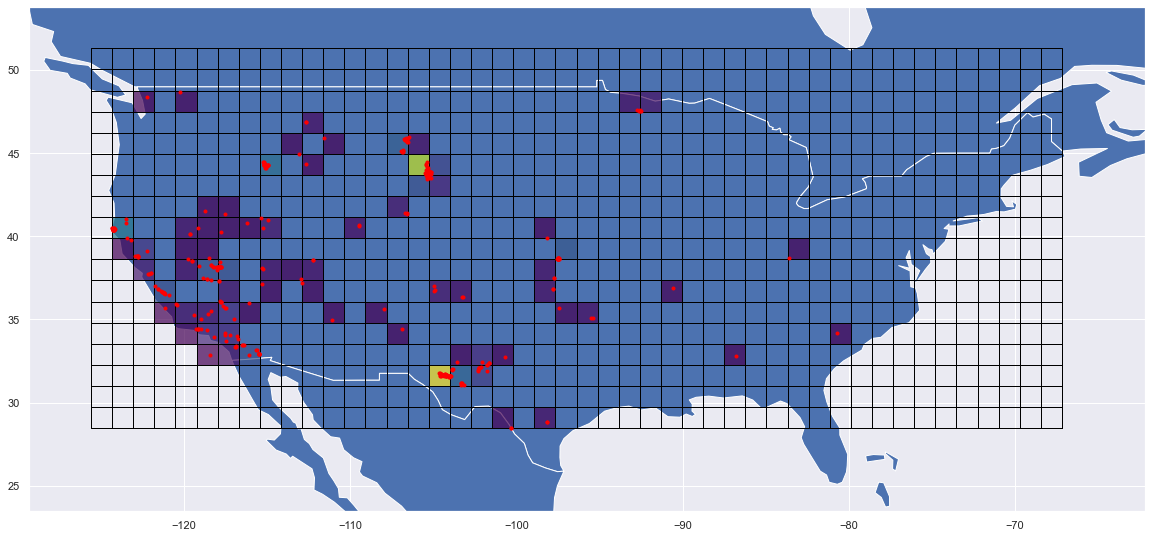

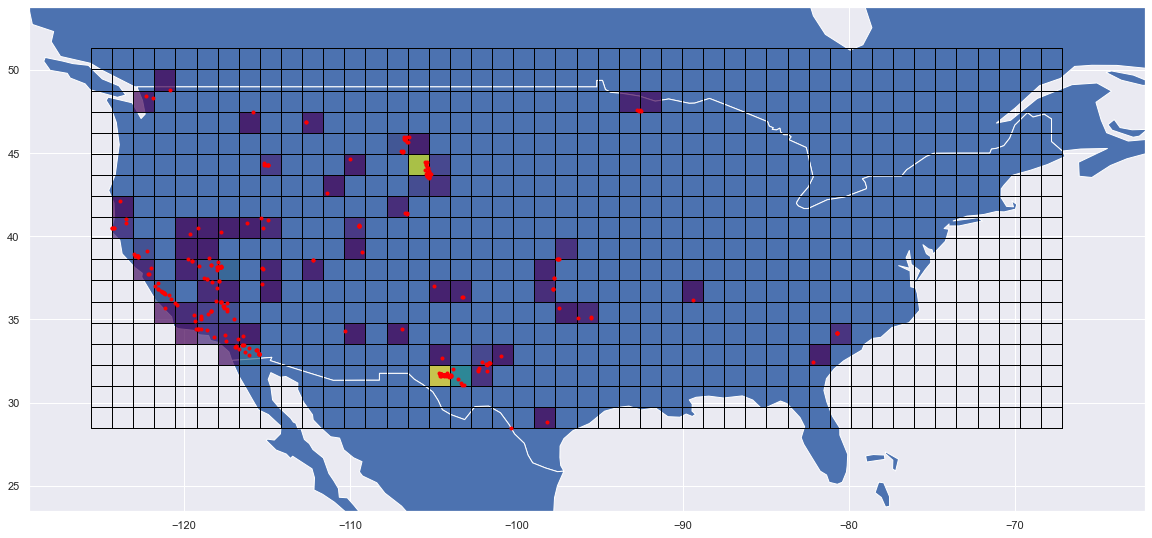

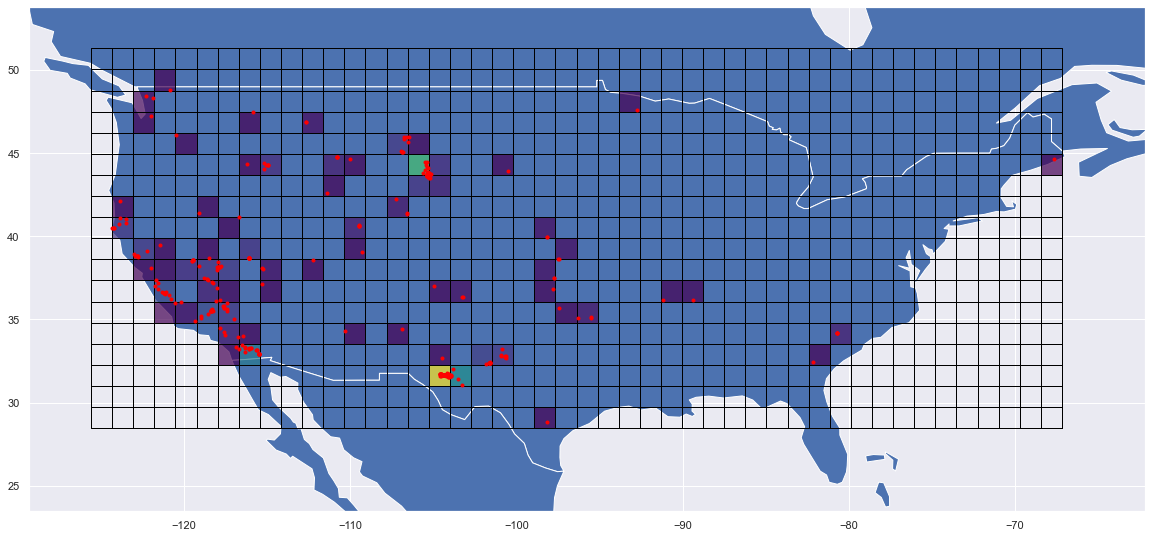

In [268]:
poimagic(geo_df,base_grid,hotspot_grid,density = 45)

# ANYTHING BELOW THIS YOU DO NOT NEED TO RUN
# ANYTHING BELOW THIS YOU DO NOT NEED TO RUN
# ANYTHING BELOW THIS YOU DO NOT NEED TO RUN
# ANYTHING BELOW THIS YOU DO NOT NEED TO RUN
# ANYTHING BELOW THIS YOU DO NOT NEED TO RUN
# ANYTHING BELOW THIS YOU DO NOT NEED TO RUN

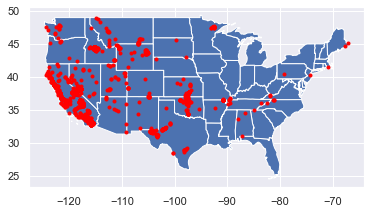

In [14]:
plt.rcParams["figure.figsize"] = [20, 20]
states = gpd.read_file('data/usa-states-census-2014.shp')
states.plot()
plt.scatter(geo_us_batch[0].longitude, geo_us_batch[0].latitude,c="red",marker='.')

In [8]:
# Geo pandas stuff only using the first batch
d = us_batch[0][:]
geo = gpd.GeoDataFrame(d.drop(['longitude', 'latitude'], axis = 1), crs='epsg:4326',geometry=[Point(xy) for xy in zip(d.longitude, d.latitude)])

#fig, ax = plt.subplots(figsize=(20,20))
#ax.set_aspect('equal')
#geo_states = gpd.read_file('data/usa-states-census-2014.shp')
#geo_states.plot(ax=ax)
#geo.plot(ax=ax, alpha=0.5, cmap='viridis', linewidth=0.8,marker='o')
#geo

In [9]:
# how many cells across and down
xmin, ymin, xmax, ymax= geo.total_bounds
n_cells=45
cell_size = (xmax-xmin)/n_cells

# create the cells in a loop
grid_cells = []
for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
    for y0 in np.arange(ymin, ymax+cell_size, cell_size):
        # bounds
        x1 = x0-cell_size
        y1 = y0+cell_size
        grid_cells.append( box(x0, y0, x1, y1)  )
cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'],crs='epsg:4326')

In [10]:
# shae code
# Takes the geo_df of batch 1
# takes the cell of batch 1
# returns the count of batch 1 cells
# WARNING takes a while to run
min_max_table=[] # is an array of cells bounds for each cell
geo_table=[]     # is an array of long and lat from batch(es)
counter=[]       # is an array that holds occurences of quakes per cell

# gives the min and max longs and lats for given cells (aka the bounds of the cell)
for i in range(len(cell)):
    xmin, ymin, xmax, ymax= cell.loc[i].geometry.bounds
    min_max_table.append([xmin,ymin,xmax,ymax])
# appends the points from the geodataframe 'Geometry.Point'
for j in range(len(geo)):
    geo_table.append([geo.geometry.x[j], geo.geometry.y[j]])

In [11]:
# first for goes through each cell then second for counts occurences in each cell
for i in range(len(cell)):
    counter.append(0)
    for j in range(len(geo)):
        if ((geo_table[j][0] < min_max_table[i][2]) & (geo_table[j][0] > min_max_table[i][0]) & (geo_table[j][1] < min_max_table[i][3]) & (geo_table[j][1] > min_max_table[i][1])):
            counter[i] +=1

In [44]:
counter

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 21,
 11,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 21,
 27,
 2,
 2,
 0,
 0,
 1,
 4,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 12,
 46,
 8,
 0,
 3,
 0,
 0,
 0,
 3,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 4,
 4,
 10,
 6,
 3,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 6,
 8,
 9,
 185,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 18,
 46,
 25,
 163,
 2,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 244,
 11,
 12,
 1,
 1,
 0,
 2,
 0,
 0,
 4,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 220,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 6,
 2,
 0,
 4,
 0,
 2,
 2,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 1,
 0,
 2,
 2,
 0,
 6,
 11,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 3,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 5,
 0,
 0,
 1,

In [34]:
# This first makes a new df, then the makes the geometry of the cells, and finally creates a GeoDataFrame
# count_df contains indiviual bounds of the cells in columns along with the count
# geo_df contains the cell bounds as a 'shape' in this case a 'box' along with the count
count_df =  pd.DataFrame(cell.loc[:].geometry.bounds)
count_df['counter'] = counter
geometry_for_frame = [box(x1,y1,x2,y2) for x1,y1,x2,y2 in zip(count_df.minx,count_df.miny, count_df.maxx,count_df.maxy)] 
geo_df = gpd.GeoDataFrame(count_df.drop(['minx','miny','maxx','maxy'], axis=1), geometry=geometry_for_frame)
geo_df.head()

test_df = geo_df.copy()
test_df
test_df.loc[26].counter

21

In [35]:
test_df[test_df.counter == 0] = np.nan

In [131]:
test_df

counter                                           geometry
0        NaN                                               None
1        NaN                                               None
2        NaN                                               None
3        NaN                                               None
4        NaN                                               None
..       ...                                                ...
823      1.0  POLYGON ((-67.15950 45.00316, -67.15950 46.274...
824      NaN                                               None
825      NaN                                               None
826      NaN                                               None
827      NaN                                               None

[828 rows x 2 columns]

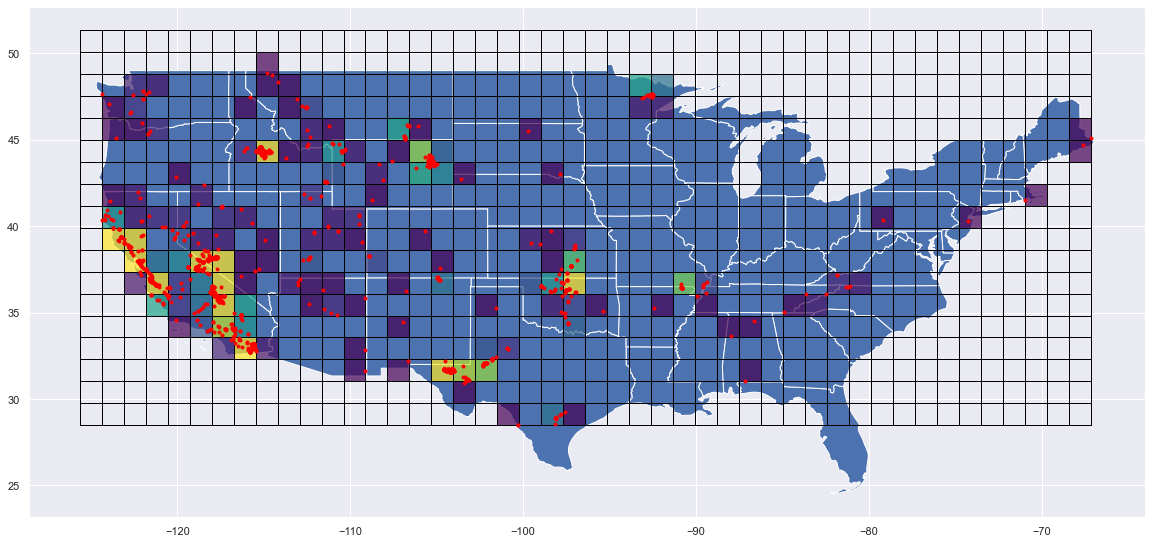

In [37]:
plt.rcParams["figure.figsize"] = [20, 20]
stat_plot=states.plot()
test_df.plot(ax = stat_plot,column="counter",edgecolor="black", cmap="viridis",vmax = 20, alpha = 0.7)
#geo_df.plot(ax = stat_plot,column="counter",edgecolor="black", cmap="viridis", vmin=10, vmax = 20, alpha = 0.7)

geo_df.plot(ax = stat_plot,facecolor="None",edgecolor="black")
plt.scatter( geo_us_batch[0].longitude, geo_us_batch[0].latitude,c="red",marker='.')
